# Evaluate sorting

author: steeve.laquitaine@epfl.ch  
last modified: 13-02-2024

**Method**:

* **delta_time (Δ𝑡)** = 1.3 ms: the time windows before and after the spike timestamp of a ground truth. When a the timestamp of a sorted unit falls within this time window, they coincide and the sorted timestamp is a hit.
* **chance level score**: see paper
* **dark (missed) units**: ground truth units with sorting accuracy below the chance agreement score (their best match with a sorted unit produce an agreement score below chance).
* **false positive units**: units which timestamps never hit the timestamps of the ground truth units wihin 50 microns of the probe: they never fall withing the delta_time window.

**New!**
* delta_time: 1.3 ms instead of 0.4 ms
* chance score: theoretically derived instead of 0.1
* false positive: units with all scores below chance 

**TODO**:
* do the same for the dense spontaneous recording: ensure that for each layer, we fully cover each layer only once, same as for neuropixels to enable a fair comparison.
Because of the multiple probe insertions we might cover a layer twice, which would oversample it and change the overall ratio of sorted unit qualities.



### Setup

1. Create or activate env `spikeinterf...`
2. Faster! Pre-compute data on cluster with: `sbatch cluster/analysis/sorting_quality.sh`

In [1]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# set project path
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.metrics import quality

# PARAMETERS
DUR = 600 # 10 minutes recording
DT = 1.3 # ms (optimized)
THR_GOOD = 0.8

# DATASETS

# NPX PROBE
# Synthetic (10m)
cfg_nb, _ = get_config("buccino_2020", "2020").values()
GT_nb_10m = cfg_nb["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
KS4_nb_10m = cfg_nb["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
KS3_nb_10m = cfg_nb["sorting"]["sorters"]["kilosort3"]["10m"]["output"]
KS2_5_nb_10m = cfg_nb["sorting"]["sorters"]["kilosort2_5"]["10m"]["output"]
KS2_nb_10m = cfg_nb["sorting"]["sorters"]["kilosort2"]["10m"]["output"]
KS_nb_10m = cfg_nb["sorting"]["sorters"]["kilosort"]["10m"]["output"]
HS_nb_10m = cfg_nb["sorting"]["sorters"]["herdingspikes"]["10m"]["output"]
REC_nb = cfg_nb["probe_wiring"]["full"]["output"]

# biophy spont (10m)
cfg_ns, _ = get_config("silico_neuropixels", "concatenated").values()
KS4_ns_10m = cfg_ns["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
KS3_ns_10m = cfg_ns["sorting"]["sorters"]["kilosort3"]["10m"]["output"]
KS2_5_ns_10m = cfg_ns["sorting"]["sorters"]["kilosort2_5"]["10m"]["output"]
KS2_ns_10m = cfg_ns["sorting"]["sorters"]["kilosort2"]["10m"]["output"]
KS_ns_10m = cfg_ns["sorting"]["sorters"]["kilosort"]["10m"]["output"]
HS_ns_10m = cfg_ns["sorting"]["sorters"]["herdingspikes"]["10m"]["output"]
GT_ns_10m = cfg_ns["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
REC_ns = cfg_ns["probe_wiring"]["full"]["output"]

# biophy evoked
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
KS4_ne_10m = cfg_ne["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
KS3_ne_10m = cfg_ne["sorting"]["sorters"]["kilosort3"]["10m"]["output"]
KS2_5_ne_10m = cfg_ne["sorting"]["sorters"]["kilosort2_5"]["10m"]["output"]
KS2_ne_10m = cfg_ne["sorting"]["sorters"]["kilosort2"]["10m"]["output"]
KS_ne_10m = cfg_ne["sorting"]["sorters"]["kilosort"]["10m"]["output"]
HS_ne_10m = cfg_ne["sorting"]["sorters"]["herdingspikes"]["10m"]["output"]
GT_ne_10m = cfg_ne["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
REC_ne = cfg_ne["probe_wiring"]["full"]["output"]

# DENSE PROBE 
# depth 1
cfg_ds1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
K4_d1 = cfg_ds1["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
K3_d1 = cfg_ds1["sorting"]["sorters"]["kilosort3"]["10m"]["output"]
K25_d1 = cfg_ds1["sorting"]["sorters"]["kilosort2_5"]["10m"]["output"]
K2_d1 = cfg_ds1["sorting"]["sorters"]["kilosort2"]["10m"]["output"]
K_d1 = cfg_ds1["sorting"]["sorters"]["kilosort"]["10m"]["output"]
H_d1 = cfg_ds1["sorting"]["sorters"]["herdingspikes"]["10m"]["output"]
R_d1 = cfg_ds1["probe_wiring"]["full"]["output"]
T_d1 = cfg_ds1["sorting"]["simulation"]["ground_truth"]["10m"]["output"]

# depth 2
cfg_ds2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
K4_d2 = cfg_ds2["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
K3_d2 = cfg_ds2["sorting"]["sorters"]["kilosort3"]["10m"]["output"]
K25_d2 = cfg_ds2["sorting"]["sorters"]["kilosort2_5"]["10m"]["output"]
K2_d2 = cfg_ds2["sorting"]["sorters"]["kilosort2"]["10m"]["output"]
K_d2 = cfg_ds2["sorting"]["sorters"]["kilosort"]["10m"]["output"]
H_d2 = cfg_ds2["sorting"]["sorters"]["herdingspikes"]["10m"]["output"]
R_d2 = cfg_ds2["probe_wiring"]["full"]["output"]
T_d2 = cfg_ds2["sorting"]["simulation"]["ground_truth"]["10m"]["output"]

# depth 3
cfg_ds3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
K4_d3 = cfg_ds3["sorting"]["sorters"]["kilosort4"]["10m"]["output"]
K3_d3 = cfg_ds3["sorting"]["sorters"]["kilosort3"]["10m"]["output"]
K25_d3 = cfg_ds3["sorting"]["sorters"]["kilosort2_5"]["10m"]["output"]
K2_d3 = cfg_ds3["sorting"]["sorters"]["kilosort2"]["10m"]["output"]
K_d3 = cfg_ds3["sorting"]["sorters"]["kilosort"]["10m"]["output"]
H_d3 = cfg_ds3["sorting"]["sorters"]["herdingspikes"]["10m"]["output"]
R_d3 = cfg_ds3["probe_wiring"]["full"]["output"]
T_d3 = cfg_ds3["sorting"]["simulation"]["ground_truth"]["10m"]["output"]


# pre-computed qualities
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/analysis/sorting_quality/sorting_quality.csv"

# FIGURE SETTINGS
# ticks
N_MJ_TCKS = 5
N_MN_TCKS = 11

# colors
# quality colors
cl = {"good": [0.7, 0.1, 0.1], # strong red
      "oversplitter": [0.6, 0.9, 0.6], # blue
      "overmerger": [0, 0.7, 1], # green
      "mixed: good + overmerger": np.array([[0.7, 0.1, 0.1], [0, 0.7, 1]]).mean(axis=0),
      "mixed: good + oversplitter": np.array([[0.7, 0.1, 0.1], [0.6, 0.9, 0.6]]).mean(axis=0),
      "mixed: overmerger + oversplitter": np.array([[0.6, 0.9, 0.6], [0, 0.7, 1]]).mean(axis=0),
      "mixed: good + overmerger + oversplitter": np.array([[0.7, 0.1, 0.1], [0, 0.7, 1],[0.6, 0.9, 0.6]]).mean(axis=0),
      "false positive": [1,1,1] # white
}

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

2024-09-12 08:58:49,813 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-12 08:58:49,846 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-12 08:58:49,847 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-12 08:58:49,879 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-12 08:58:49,881 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-12 08:58:49,928 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-12 08:58:49,929 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-12 08:58:49,974 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-12 08:58:49,975 - root - utils.py - get_config - INFO - Reading experiment config.
2024-09-12 08:58:50,016 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-09-12 08:58:50,017 - root - utils.py - get_config 

### (1m)Scores

* sorted single-units only
* 10 minutes recordings
* for the dense probe, sorted units filtered such that there is no overepresentation of a layer: from L1, L2/3 from depth 1, L4,5 (depth 2), L6 (depth 3)


### (60m)Chance scores

* sorted single-units only
* chance scores are derived theoretically

### (36m)Evaluate sorted units


In [2]:
# read pre-computed data
df = pd.read_csv(quality_path)

# rename "outside" layer for plot
df[df["layer"] == "Outside"] = "Out"

### Plot by layer x sorter x experiment

/tmp/ipykernel_233043/1173705262.py:81: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0, hspace=1)


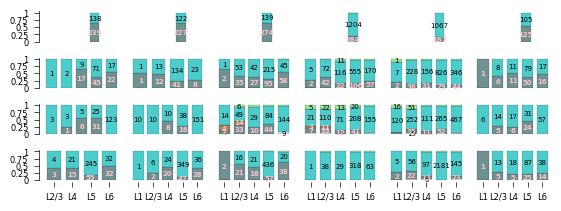

In [5]:
# spike sorters
sorter = ["KS4", "KS3", "KS2.5", "KS2", "KS", "HS"]

# plot
fig = plt.figure(figsize=(5.5, 2), layout="constrained")
spec = fig.add_gridspec(ncols=len(sorter), nrows=4)

# loop over sorter (grid columns)
for s_ix, sorter_i in enumerate(sorter):

    # S
    ax = fig.add_subplot(spec[0, s_ix])
    ax = quality._plot_ratio_by_layer(
        ax,
        df[(df["sorter"] == sorter_i) & (df["experiment"] == "S")],
        cl,
        legend_cfg,
        False,
        False,
    )
    ax.set_xlim([-4, 2])
    if s_ix == 0:
        ax.spines["left"].set_visible(True)
        ax.set_yticks([0, 25, 50, 75, 100], [0, 0.25, 0.5, 0.75, 1])
    else:
        ax.set_yticks([])
    ax.set_xticks([])

    # NS
    ax = fig.add_subplot(spec[1, s_ix])
    ax = quality._plot_ratio_by_layer(
        ax,
        df[(df["sorter"] == sorter_i) & (df["experiment"] == "NS")],
        cl,
        legend_cfg,
        False,
        False,
    )
    if s_ix == 0:
        ax.spines["left"].set_visible(True)
        ax.set_yticks([0, 25, 50, 75, 100], [0, 0.25, 0.5, 0.75, 1])
    else:
        ax.set_yticks([])
    ax.set_xticks([])

    # DS
    ax = fig.add_subplot(spec[2, s_ix])
    ax = quality._plot_ratio_by_layer(
        ax,
        df[(df["sorter"] == sorter_i) & (df["experiment"] == "DS")],
        cl,
        legend_cfg,
        False,
        False,
    )
    if s_ix == 0:
        ax.spines["left"].set_visible(True)
        ax.set_yticks([0, 25, 50, 75, 100], [0, 0.25, 0.5, 0.75, 1])
    else:
        ax.set_yticks([])
    ax.set_xticks([])

    # E
    ax = fig.add_subplot(spec[3, s_ix])
    ax = quality._plot_ratio_by_layer(
        ax,
        df[(df["sorter"] == sorter_i) & (df["experiment"] == "E")],
        cl,
        legend_cfg,
        False,
        False,
    )
    if s_ix == 0:
        ax.spines["left"].set_visible(True)
        ax.set_yticks([0, 25, 50, 75, 100], [0, 0.25, 0.5, 0.75, 1])
    else:
        ax.set_yticks([])

# tidy
# fig.tight_layout(**tight_layout_cfg)
plt.subplots_adjust(wspace=0, hspace=1)

# save
utils.savefig("figures/1_sorting_quality/yield/assets/fig5C_sorting_quality.svg")

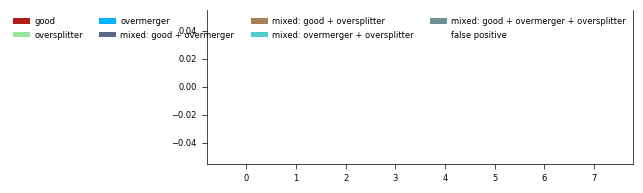

In [4]:
# create full legend
fig, ax = plt.subplots(figsize=(5.5, 2))
ax = plt.bar(
    np.arange(0, len(cl.keys()), 1),
    np.zeros(len(cl.keys())),
    color=cl.values(),
    label=cl.keys(),
)
plt.legend(**legend_cfg, ncol=4)
utils.savefig("figures/1_sorting_quality/yield/assets/fig5C_sorting_quality_lgd.svg")

### References

(1) https://neuronaldynamics.epfl.ch/online/Ch7.S2.html